# Data Preperation

In [16]:
# loading the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [34]:
# Helper Functions

# Bar Plot
def target_distribution(data, target, title='Target Distribution'):
    '''
        This fuction displays the distribution of the specified numeric variable in the input data frame.
        
        params:
        data: input data frame.
        target: string specifying the name of target variable.
        
        Returns: None.
        
    '''
    data = data.copy()
    sns.countplot(data=data,x=target,palette=['black','gray']);
    tgt_cnt = data[target].value_counts()
    tgt_prop = np.round(data[target].value_counts(normalize=True)*100,1)
    plt.text(x=-0.2,y=tgt_cnt[0]/2,s=f'{tgt_cnt[0]:,} ({tgt_prop[0]}%)',backgroundcolor='white')
    plt.text(x=0.8,y=tgt_cnt[1]/2,s=f'{tgt_cnt[1]:,} ({tgt_prop[1]}%)',backgroundcolor='white')
    plt.title(title)
    plt.show()
    return None
    

In [45]:
unbalanced_df = pd.read_pickle("../Data Folder/fake_job_postings_dd_raw_df.pkl") 
unbalanced_df.head(2)

numeric_variables = list(unbalanced_df.select_dtypes(['float64','int64']).columns)

unbalanced_df = unbalanced_df[numeric_variables]

# Data Test/Train Split
We will now split the train dataset into train and validation set.
We will keeep 20% of data for validation.

In [46]:
target = 'fraudulent'
X_train,X_test,y_train,y_test=train_test_split(unbalanced_df.drop(target,axis=1),
                                               unbalanced_df[target].astype('uint8'),
                                               test_size=.2,
                                               random_state=1)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (14079, 3)
X_test shape: (3520, 3)
y_train shape: (14079,)
y_test shape: (3520,)


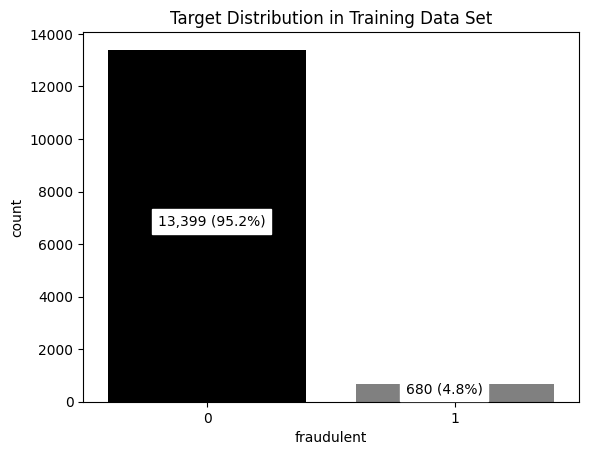

In [47]:
# Review the distribution of the target variable for the Training data set
train_y = pd.DataFrame(y_train, columns = [target])

target_distribution(data=train_y,
                    target=target,
                    title='Target Distribution in Training Data Set')

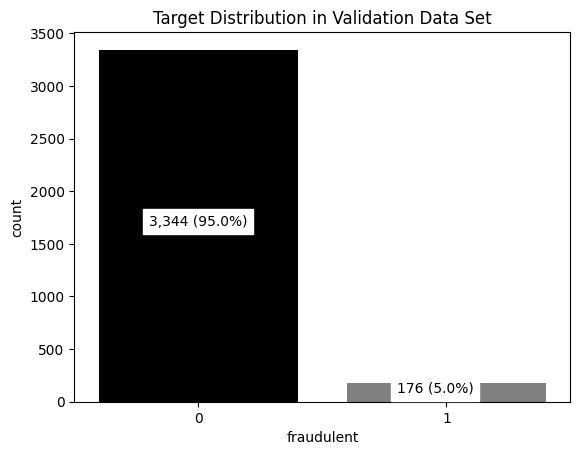

In [48]:
# Review the distribution of the target variable for the validation data set
validate_y = pd.DataFrame(y_test, columns = [target])

target_distribution(data=validate_y,
                    target=target,
                    title='Target Distribution in Validation Data Set')

# Rebalance Train Data

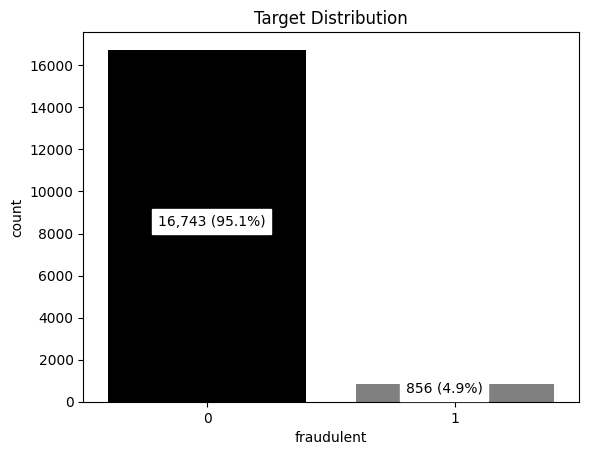

In [49]:
# Plot Target Variable fraudulent distribution.

target_distribution(data=unbalanced_df,
                    target=target)

## Over-sampling: SMOTE
SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

<img src="../Image%20Folder/Markdown%20Images/smote.png" 
        alt="Over-sampling: SMOTE" 
        style="display: block; margin: 0 auto" />



In [58]:

smote = SMOTE(sampling_strategy='minority')

X_sm, y_sm = smote.fit_resample(X_train,y_train)

